# Bite Size Bayes

Copyright 2020 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Review

[In a previous notebook](https://colab.research.google.com/github/AllenDowney/BiteSizeBayes/blob/master/09_predict.ipynb) we used the time between goals to update our estimate of the goal-scoring rate of a soccer team.

Under the assumption that goal-scoring is well-modeled by a Poisson process, the time between goals follows an [exponential distribution](https://en.wikipedia.org/wiki/Exponential_distribution).

In other words, if the goal-scoring rate is λ, the probability of seeing an interval between goals of $t$ is proportional to the PDF of the exponential distribution:

$f(t; λ) = λ~\exp(-λ t)$

Because $t$ is a continuous quantity, the value of this expression is not really a probability; technically it is a [probability density](https://en.wikipedia.org/wiki/Probability_density_function).  However, it is proportional to the probability of the data, so we can use it as a likelihood in a Bayesian update.

In this notebook, we'll use the PDF of a normal distribution the same way, in order to estimate the value of prizes on a game show.
Once we compute a posterior distribution, we'll use it to optimize a decision-making process.

This example demonstrates the real power of Bayesian methods, not just computing posterior distributions, but using them to make better decisions.

## The Price is Right problem

On November 1, 2007, contestants named Letia and Nathaniel appeared on *The Price is Right*, an American game show. They competed in a game called "The Showcase", where the objective is to guess the price of a collection of prizes. The contestant who comes closest to the actual price, without going over, wins the prizes.

Nathaniel went first. His showcase included a dishwasher, a wine cabinet, a laptop computer, and a car. He bid $26,000.

Letia’s showcase included a pinball machine, a video arcade game, a pool table, and a cruise of the Bahamas. She bid $21,500.

The actual price of Nathaniel’s showcase was $25,347. His bid was too high, so he lost.

The actual price of Letia’s showcase was $21,578. 

She was only off by $78, so she won her showcase and, because her bid was off by less than 250, she also won Nathaniel’s showcase.

For a Bayesian thinker, this scenario suggests several questions:

1. Before seeing the prizes, what prior beliefs should the contestant have about the price of the showcase?

2. After seeing the prizes, how should the contestant update those beliefs?

3. Based on the posterior distribution, what should the contestant bid?

The third question demonstrates a common use of Bayesian methods: [decision analysis](https://en.wikipedia.org/wiki/Decision_analysis).

This problem is inspired by [this example](https://nbviewer.jupyter.org/github/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter5_LossFunctions/Ch5_LossFunctions_PyMC3.ipynb) in Cameron Davidson-Pilon’s book, [Probablistic Programming and Bayesian Methods for Hackers](http://camdavidsonpilon.github.io/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers).

## The prior

To choose a prior distribution of prices, we can take advantage of data from previous episodes. Fortunately, [fans of the show keep detailed records](https://web.archive.org/web/20121107204942/http://www.tpirsummaries.8m.com/). 

For this example, I downloaded files containing the price of each showcase from the 2011 and 2012 seasons and the bids offered by the contestants.

The following cells load the data files.

In [2]:
# Load the data files
import os

if not os.path.exists('showcases.2011.csv'):
    !wget https://github.com/AllenDowney/BiteSizeBayes/raw/master/showcases.2011.csv

if not os.path.exists('showcases.2012.csv'):
    !wget http://github.com/AllenDowney/BiteSizeBayes/raw/master/showcases.2012.csv

The following function reads the data and cleans it up a little.

In [3]:
def read_data(filename):
    """Read the showcase price data.
    
    filename: string
    
    returns: DataFrame
    """
    df = pd.read_csv(filename, index_col=0, skiprows=[1])
    return df.dropna().transpose()

I'll read both files and concatenate them.

In [4]:
df2011 = read_data('showcases.2011.csv')
df2011.shape

(191, 6)

In [5]:
df2012 = read_data('showcases.2012.csv')
df2012.shape

(122, 6)

In [6]:
df = pd.concat([df2011, df2012], ignore_index=True)
df.shape

(313, 6)

Here's what the dataset looks like:

In [7]:
df.head()

,Showcase 1,Showcase 2,Bid 1,Bid 2,Difference 1,Difference 2
0,50969.0,45429.0,42000.0,34000.0,8969.0,11429.0
1,21901.0,34061.0,14000.0,59900.0,7901.0,-25839.0
2,32815.0,53186.0,32000.0,45000.0,815.0,8186.0
3,44432.0,31428.0,27000.0,38000.0,17432.0,-6572.0
4,24273.0,22320.0,18750.0,23000.0,5523.0,-680.0


## Kernel density estimation

This dataset contains the prices for 313 previous showcases, which we can think of as a sample from the population of possible prices.

We can use this sample to estimate the prior distribution of showcase prices.  One way to do that is kernel density estimation (KDE), which uses the sample to estimate a smooth distribution.

SciPy provides `gaussian_kde`, which takes a sample and returns an object that represents the estimated distribution.

In [8]:
from scipy.stats import gaussian_kde

kde = gaussian_kde(df['Showcase 1'])
kde

We can use `kde` to evaluate the estimated distribution for a sequence of values:

In [9]:
xs = np.linspace(0, 80000, 81)
ps = kde(xs)

And put the results into a normalized Series that represents the prior distribution for Showcase 1.

In [10]:
def make_pmf(xs, ps, **options):
    """Make a Series that represents a PMF.
    
    xs: sequence of values
    ps: sequence of probabilities
    options: keyword arguments passed to Series constructor
    
    returns: Pandas Series
    """
    pmf = pd.Series(ps, index=xs, **options)
    return pmf

In [11]:
prior1 = make_pmf(xs, ps)
prior1 /= prior1.sum()

Here's what it looks like:

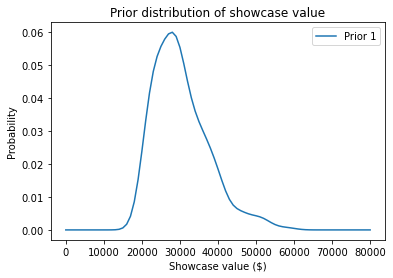

In [12]:
prior1.plot(label='Prior 1')

plt.xlabel('Showcase value ($)')
plt.ylabel('Probability')
plt.title('Prior distribution of showcase value')
plt.legend();

The following function takes a sample, makes a KDE, evaluates it at a given sequence of `xs`, and returns the result as a normalized PMF.

In [13]:
def make_kde(xs, sample):
    """Make a PMF based on KDE:
    
    xs: places where we should evaluate the KDE
    sample: sequence of values
    
    returns: Series that represents a normalized PMF
    """
    kde = gaussian_kde(sample)
    ps = kde(xs)
    pmf = make_pmf(xs, ps)
    pmf /= pmf.sum()
    return pmf

**Exercise:** Use this function to make a Pmf that represents the prior distribution for Showcase 2, and plot it.

In [14]:
# Solution

xs = np.linspace(10000, 80000, 71)
prior2 = make_kde(xs, df['Showcase 2'])

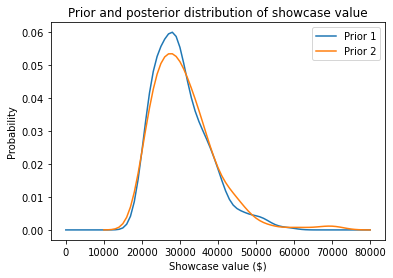

In [15]:
# Solution

prior1.plot(label='Prior 1')
prior2.plot(label='Prior 2')

plt.xlabel('Showcase value ($)')
plt.ylabel('Probability')
plt.title('Prior and posterior distribution of showcase value')
plt.legend();

## Distribution of error

To update these priors, we have to answer these questions:

* What data should we consider and how should we quantify it?

* Can we compute a likelihood function; that is, for each hypothetical price, can we compute the conditional likelihood of the data?

To answer these questions, I will model the contestant as a price-guessing instrument with known error characteristics. In other words, when the contestant sees the prizes, they guess the price of each prize --- ideally without taking into consideration the fact that the prize is part of a showcase --- and add up the prices. Let’s call this total `guess`.

Under this model, the question we have to answer is, “If the actual price is `price`, what is the likelihood that the contestant’s estimate would be `guess`?”

Equivalently, if we define `error = guess - price`, we can ask, “What is the likelihood that the contestant’s estimate is off by `error`?”

To answer this question, I'll use the historical data again. For each showcase in the dataset, let's look at the difference between the contestant's bid and the actual price:

In [16]:
sample_diff1 = df['Bid 1'] - df['Showcase 1']
sample_diff2 = df['Bid 2'] - df['Showcase 2']

To visualize the distribution of these differences, we can use KDE again.

In [17]:
xs = np.linspace(-40000, 20000, 61)
kde_diff1 = make_kde(xs, sample_diff1)
kde_diff2 = make_kde(xs, sample_diff2)

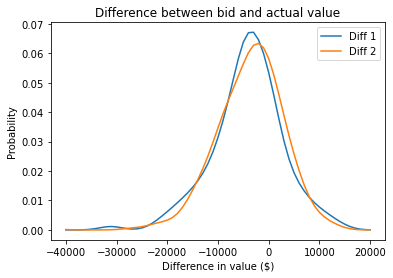

In [18]:
kde_diff1.plot(label='Diff 1')
kde_diff2.plot(label='Diff 2')

plt.xlabel('Difference in value ($)')
plt.ylabel('Probability')
plt.title('Difference between bid and actual value')
plt.legend();

It looks like the bids are too low more often than too high, which makes sense.  Remember that under the rules of the game, you lose if you overbid, so contestants probably underbid to some degree deliberately.

Here is the mean and standard deviation of `Diff` for Player 1.

In [19]:
mean_diff1 = sample_diff1.mean()
std_diff1 = sample_diff1.std()

mean_diff1, std_diff1

(-4116.3961661341855, 6899.909806377115)

We can use the observed distribution of differences to model the contestant's distribution of errors.

This step is a little tricky because we don’t actually know the contestant’s guesses; we only know what they bid.

So we have to make some assumptions:

* I'll assume that contestants underbid because they are being strategic, and that on average their guesses are accurate.  In other word, the mean of their errors is 0.

* But I'll assume that the spread of the differences reflects the actual spread of their errors.  So, I'll use the standard deviation of the differences as the standard deviation of their errors.

Based on these assumptions, I'll make a normal distribution with parameters 0 and `std_diff1`.

In [20]:
from scipy.stats import norm

error_dist1 = norm(0, std_diff1)
error_dist1

We'll use this distribution to do the update.

## Update

Suppose you are Player 1.  You see the prizes in your showcase and your estimate of the total price is $23,000.

For each hypothetical price in the prior distribution, I'll subtract away your guess.
The result is your error under each hypothesis.

In [21]:
guess1 = 23000

xs = prior1.index
error1 = guess1 - xs

Now suppose you know based on past performance that your estimation error is well modeled by `error_dist1`.

Under that assumption we can compute the likelihood of your estimate under each hypothesis.

In [22]:
likelihood1 = error_dist1.pdf(error1)

And we can use that likelihood to update the prior.

In [23]:
posterior1 = prior1 * likelihood1
posterior1 /= posterior1.sum()

Here's what the posterior distribution looks like:

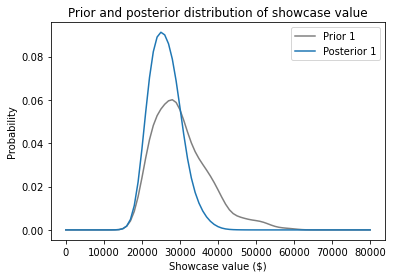

In [24]:
prior1.plot(color='gray', label='Prior 1')
posterior1.plot(color='C0', label='Posterior 1')

plt.xlabel('Showcase value ($)')
plt.ylabel('Probability')
plt.title('Prior and posterior distribution of showcase value')
plt.legend();

Because your estimate is in the lower end of the range, the posterior distribution has shifted to the left.  We can use the posterior mean to see by how much.

In [25]:
def pmf_mean(pmf):
    """Compute the mean of a PMF.
    
    pmf: Series representing a PMF
    
    return: float
    """
    return np.sum(pmf.index * pmf)

In [26]:
pmf_mean(prior1), pmf_mean(posterior1)

(30299.488817891375, 26192.02400239254)

Before you saw the prizes, you expected to see a showcase with a value close to $30,000.

After making an estimate of $23,000, you updated the prior distribution.

Based on the combination of the prior and your estimate, you now expect the actual price to be about $26,000.

**Exercise:** Now suppose you are Player 2.  When you see your showcase, you estimte that the total price is $38,000.

Use `diff2` to construct a normal distribution that represents the distribution of your estimation errors.

Compute the likelihood of your estimate for each actual price and use it to update `prior2`.

Plot the posterior distribution and compute the posterior mean.  Based on your estimate, what do you expect the actual price of the showcase to be?

In [27]:
# Solution

mean_diff2 = sample_diff2.mean()
std_diff2 = sample_diff2.std()

mean_diff2, std_diff2

(-3675.891373801917, 6886.26071132341)

In [28]:
# Solution

error_dist2 = norm(0, std_diff2)

In [29]:
# Solution

guess2 = 38000
xs = prior2.index
error2 = guess2 - xs

likelihood2 = error_dist2.pdf(error2)

In [30]:
# Solution

posterior2 = prior2 * likelihood2
posterior2 /= posterior2.sum()

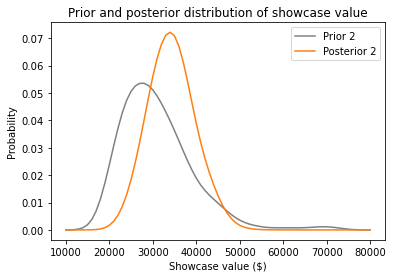

In [31]:
# Solution

prior2.plot(color='gray', label='Prior 2')
posterior2.plot(color='C1', label='Posterior 2')

plt.xlabel('Showcase value ($)')
plt.ylabel('Probability')
plt.title('Prior and posterior distribution of showcase value')
plt.legend();

In [32]:
# Solution

pmf_mean(prior2), pmf_mean(posterior2)

(31047.686915520928, 34305.20163595075)

## Probability of winning

Now that we have a posterior distribution for each player, let's think about strategy.

First, from the point of view of Player 1, let's compute the probability that Player 2 overbids.  To keep it simple, I'll use only the performance of past players, ignoring the estimated value of the showcase. 

The following function takes a sequence of past bids and returns the fraction that overbid.

In [33]:
def prob_overbid(sample_diff):
    """Returns the probability this player overbids.

    sample_diff: sequence of differences
    """
    return np.mean(sample_diff > 0)

Here's an estimate for the probability that Player 2 overbids.

In [34]:
prob_overbid(sample_diff2)

0.29073482428115016

Now suppose Player 1 underbids by $5000.
What is the probability that Player 2 underbids by more?

The following function uses past performance to estimate the probabily that a player underbids by more than a given amount, `diff`:

In [35]:
def prob_worse_than(diff, sample_diff):
    """Probability the opponents's diff is worse than the given diff.

    diff: how much the oppenent is off by (always negative)
    sample_diff: sequence of differences for the opponent
    """
    return np.mean(sample_diff < diff)

Here's the probability that Player 2 underbids by more than $5000.

In [36]:
prob_worse_than(-5000, sample_diff2)

0.38338658146964855

And here's the probability they are off by more than $10,000.

In [37]:
prob_worse_than(-10000, sample_diff2)

0.14376996805111822

We can combine these function to compute the probability that Player 1 wins, given the difference between their bid and the actual price:

In [38]:
def compute_prob_win(diff, sample_diff):
    """Computes the probability of winning for a given diff.

    diff: how much your bid was off by
    sample_diff: sequence of differences for the opponent
    """
    # if you overbid you lose
    if diff > 0:
        return 0
    
    # if the opponent over bids, you win
    p1 = prob_overbid(sample_diff)
    
    # or of their bid is worse than yours, you win
    p2 = prob_worse_than(diff, sample_diff)
    return p1 + p2

Here's the probability that you win, given that you underbid by $5000.

In [39]:
compute_prob_win(-5000, sample_diff2)

0.6741214057507987

Now let's look at the probability of winning for a range of possible differences.

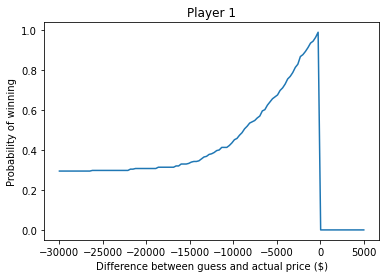

In [40]:
xs = np.linspace(-30000, 5000, 121)
ys = [compute_prob_win(x, sample_diff2) for x in xs]

plt.plot(xs, ys)
plt.xlabel('Difference between guess and actual price ($)')
plt.ylabel('Probability of winning')
plt.title('Player 1');

If you underbid by $30,000, the chance of winning is about 30%, which is mostly the chance your opponent overbids.

As your bids gets closer to the actual price, your chance of winning approaches 1.

And, of course, if you overbid, you lose (even if your opponent also overbids).

**Exercise:** Run the same analysis from the point of view of Player 2.  Using the sample of differences from Player 1, compute:

1. The probability that Player 1 overbids.

2. The probability that Player 1 underbids by more than $5000.

3. The probability that Player 2 wins, given that they underbid by $5000.

Then plot the probability that Player 2 wins for a range of possible differences between their bid and the actual price.

In [41]:
prob_overbid(sample_diff1)

0.24600638977635783

In [42]:
prob_worse_than(-5000, sample_diff1)

0.3993610223642173

In [43]:
compute_prob_win(-5000, sample_diff1)

0.6453674121405751

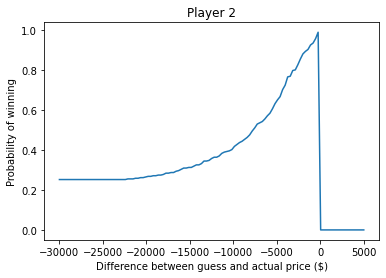

In [44]:
xs = np.linspace(-30000, 5000, 121)
ys = [compute_prob_win(x, sample_diff1) for x in xs]

plt.plot(xs, ys)
plt.xlabel('Difference between guess and actual price ($)')
plt.ylabel('Probability of winning')
plt.title('Player 2');

## Decision analysis

In the previous section we computed the probability of winning, given that we have underbid by a particular amount.

In reality the contestants don't know how much they have underbid by, because they don't know the actual price.

But they do have a posterior distribution that represents their beliefs about the actual price, and they can use that to estimate their probability of winning with a given bid.

The following function take a possible bid, a posterior distribution of actual prices, and a sample of differences for the opponent.

It loops through the hypothetical prices in the posterior distribution and for each price:

1. Computes the difference between the bid and the hypothetical price.

2. Computes the probability that the player wins, given that difference.

3. Adds up the weighted sum of the probabilities, where the weights are the probabilites in the posterior distribution. 

In [45]:
def total_prob_win(bid, posterior, sample_diff):
    """Computes the total probability of winning with a given bid.

    bid: your bid
    posterior: Pmf of showcase value
    sample_diff: sequence of differences for the opponent
    
    returns: probability of winning
    """
    total = 0
    for price, prob in posterior.items():
        diff = bid - price
        total += prob * compute_prob_win(diff, sample_diff)
    return total

This loop implements the law of total probability:

$P(win) = \sum_{price} P(price) ~ P(win ~|~ price)$

In [46]:
total_prob_win(25000, posterior1, sample_diff2)

0.4842210945439813

In [47]:
bids = posterior1.index

probs = [total_prob_win(bid, posterior1, sample_diff2) 
         for bid in bids]

prob_win_series = pd.Series(probs, index=bids)

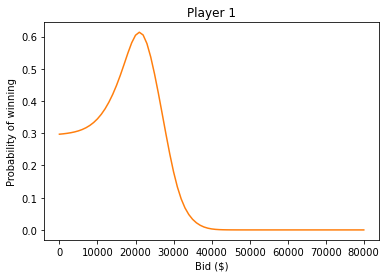

In [48]:
prob_win_series.plot(color='C1')

plt.xlabel('Bid ($)')
plt.ylabel('Probability of winning')
plt.title('Player 1');

And here's the bid that maximizes your chance of winning.

In [49]:
prob_win_series.idxmax()

21000.0

Recall that your estimate was $23,000.

After using your estimate to compute the posterior distribution, the posterior mean is about $26,000.

But the bid that maximizes your chance of winning is $21,000.

**Exercise:** Do the same analysis for Player 2.

In [50]:
# Solution

bids = posterior2.index

probs = [total_prob_win(bid, posterior2, sample_diff1) 
         for bid in bids]

prob_win_series = pd.Series(probs, index=bids)

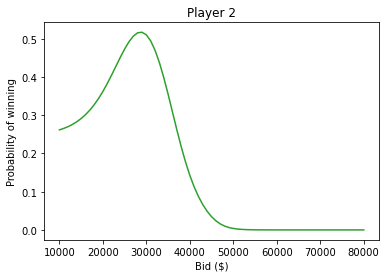

In [51]:
# Solution

prob_win_series.plot(color='C2')

plt.xlabel('Bid ($)')
plt.ylabel('Probability of winning')
plt.title('Player 2');

In [52]:
# Solution

prob_win_series.idxmax()

29000.0

## Maximizing expected gain

In the previous section we computed the bid that maximizes your chance of winning.
And if that's your goal, the bid we computed is optimal.

But winning isn't everything.
Remember that if your bid is off by $250 or less, you will both showcases.
So it might be a good idea to increase your bid a little: it increases the chance you overbid and lose, but it also increases the chance of winning both showcases.

Let's see how that works out.
The following function computes how much you will win, on average, given your bid, the actual price, and a sample of errors for your opponent.

In [53]:
def compute_gain(bid, price, sample_diff):
    """Computes expected gain given a bid and actual price.

    bid: number
    price: actual price
    sample_diff: sequence of differences for the opponent
    """
    diff = bid - price
    prob = compute_prob_win(diff, sample_diff)

    # if you are within 250 dollars, you win both showcases
    if -250 <= diff <= 0:
        return 2 * price * prob
    else:
        return price * prob

For example, if the actual price is $35000 

and you bid $30000, 

you will win about $23,600 worth of prizes on average.

In [54]:
compute_gain(30000, 35000, sample_diff2)

23594.249201277955

In reality we don't know the actual price, but we have a posterior distribution that represents what we know about it.
By averaging over the prices and probabilities in the posterior distribution, we can compute the "expected gain" for a particular bid.

In [55]:
def expected_gain(bid, posterior, sample_diff):
    """Computes the expected return of a given bid.

    bid: your bid
    posterior: distribution of showcase values
    sample_diff: distribution of differences for the opponent
    """
    total = 0
    for price, prob in posterior.items():
        total += prob * compute_gain(bid, price, sample_diff)
    return total

For the posterior we computed earlier, based on an estimate of $23,000, 

the expected gain for a bid of $21,000

is about $16,900.

In [56]:
expected_gain(21000, posterior1, sample_diff2)

16923.59933856512

But can we do any better? 

To find out, we can loop through a range of bids and find the one that maximizes expected gain.

In [57]:
bids = posterior1.index

gains = [expected_gain(bid, posterior1, sample_diff2) for bid in bids]

expected_gain_series = pd.Series(gains, index=bids)

Here are the results.

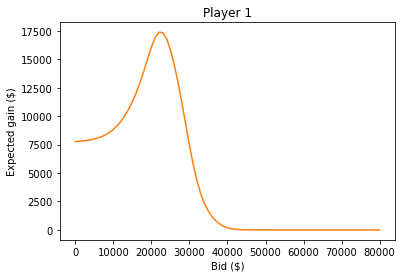

In [58]:
expected_gain_series.plot(color='C1')

plt.xlabel('Bid ($)')
plt.ylabel('Expected gain ($)')
plt.title('Player 1');

And here is the optimal bid.

In [59]:
expected_gain_series.idxmax()

22000.0

With that bid, the expected gain is about $17,400.

In [60]:
expected_gain_series.max()

17384.8995844308

Recall that the estimated value of the prizes was $23,000.

The bid that maximizes the chance of winning is $21,000.

And the bid that maximizes your the expected gain is $22,000.

**Exercise:** Do the same analysis for Player 2.

In [61]:
bids = posterior2.index

gains = [expected_gain(bid, posterior2, sample_diff1) for bid in bids]

expected_gain_series = pd.Series(gains, index=bids)

Here are the results.

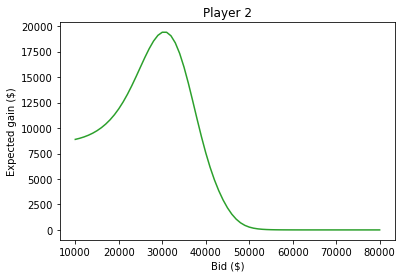

In [62]:
expected_gain_series.plot(color='C2')

plt.xlabel('Bid ($)')
plt.ylabel('Expected gain ($)')
plt.title('Player 2');

And here is the optimal bid.

In [63]:
expected_gain_series.idxmax()

30000.0

## Review

In this notebook

[In the next notebook](https://colab.research.google.com/github/AllenDowney/BiteSizeBayes/blob/master/13_xxx.ipynb)